# Models load

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import os

path_to_models = '../models'

def load_models(path):
    trained_models = []
    for root, _, _ in os.walk(path):
        if os.path.basename(root) == 'model_1_CNN':
            trained_models.append(keras.models.load_model(root))
            
    return trained_models

trained_models = load_models(path_to_models)

2022-04-22 08:20:37.254517: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-22 08:20:39.377205: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-22 08:20:39.385800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-22 08:20:39.456759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 08:20:39.457814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 3GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 9 deviceMemorySize: 2.95GiB deviceMemoryBandwidth: 178.99GiB/s
2022-04-22 08:20:39.457872: I tensorflow/stream_executor/platfor

# Data load

In [2]:
import pandas as pd

path_to_data='../data/esd'
imgs_path='../imgs/ood_data_esd/'

def load_data(path):
    emotion, file_path = [], []
    
    # iterate over audio files extracting emotion label, file path and speaker info
    for root, _, files in os.walk(path):
        if len(files): # extract info only if files are found
            for filename in files:
                if filename.split('.')[1] == 'wav':
                    temp_path_split = os.path.dirname(root).split('/')
                    emotion.append(temp_path_split[4])
                    file_path.append(os.path.join(root, filename))

    # prepare dataframe
    audio_df = pd.DataFrame(emotion)
    audio_df = audio_df.replace({'Happy': 'happiness', 'Neutral': 'neutral', 'Surprise': 'surprise'
                                'Sad': 'sadness', 'Angry': 'anger'})
    
    audio_df = pd.concat([pd.DataFrame(file_path), audio_df], axis=1)
    audio_df.columns = ['path', 'emotion']
    
    return audio_df

df = load_data(path_to_data)
df

,path,emotion
0,../data/esd/0015/Happy/evaluation/0015_000717.wav,Happy
1,../data/esd/0015/Happy/evaluation/0015_000706.wav,Happy
2,../data/esd/0015/Happy/evaluation/0015_000704.wav,Happy
3,../data/esd/0015/Happy/evaluation/0015_000715.wav,Happy
4,../data/esd/0015/Happy/evaluation/0015_000702.wav,Happy
...,...,...
34995,../data/esd/0012/Neutral/train/0012_000300.wav,Neutral
34996,../data/esd/0012/Neutral/train/0012_000090.wav,Neutral
34997,../data/esd/0012/Neutral/train/0012_000296.wav,Neutral
34998,../data/esd/0012/Neutral/train/0012_000054.wav,Neutral


# Plots

## class distribution

['Happy' 'Surprise' 'Angry' 'Sad' 'Neutral']


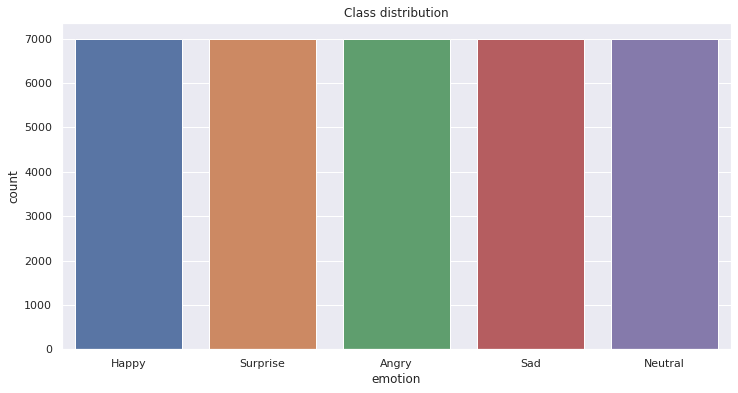

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
def class_imbalance_plot():
    print(df['emotion'].unique())
    plt.figure(figsize = (12,6))
    sns.set_theme(style='darkgrid')
    sns.countplot(x = 'emotion', data = df)
    plt.title('Class distribution')
    plt.savefig(imgs_path + 'class_distribution.png')
    plt.show()
    return

class_imbalance_plot()

# Feature extraction

- [mfcc extraction info](https://www.researchgate.net/profile/Teddy-Gunawan/publication/353296706_Speech_Emotion_Recognition_Using_Feature_Fusion_of_TEO_and_MFCC_on_Multilingual_Databases/links/613ef96f4e1df2710631ca0a/Speech-Emotion-Recognition-Using-Feature-Fusion-of-TEO-and-MFCC-on-Multilingual-Databases.pdf)
- [librosa docs](https://librosa.org/doc/latest/index.html)

In [4]:
'''
import librosa

# length of the longest utterance

def longest_utterance_length(df):
    longest_utterance = 0
    for file in df['path']:
        wavf, sample_rate = librosa.load(file, res_type='kaiser_fast', sr=44100)
        curr_length = librosa.get_duration(y=wavf, sr=sample_rate)
        if curr_length > longest_utterance:
            longest_utterance = curr_length
            
    return longest_utterance

_duration = longest_utterance_length(df)

print(_duration)
'''

In [6]:
# mfcc features
def parse_audio_file(path_to_file, _sr, _duration):
    # load file
    wavf, sample_rate = librosa.load(path_to_file, res_type="kaiser_fast", duration=_duration, sr=_sr)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 44100, 8)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,emotion,0,1,2,3,4,5,6,7,8,...,686,687,688,689,690,691,692,693,694,695
0,Happy,-49.180321,-49.180321,-49.180321,-49.180321,-49.180321,-49.180321,-49.180321,-49.180321,-32.914463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Happy,-54.225517,-54.225517,-54.225517,-54.225517,-54.225517,-54.225517,-54.225517,-54.225517,-54.225517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Happy,-35.421291,-32.140652,-31.178898,-30.357868,-32.065575,-32.248047,-32.211929,-32.116116,-32.252506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Happy,-51.581966,-51.581966,-51.581966,-51.581966,-51.581966,-51.581966,-51.581966,-51.581966,-51.581966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Happy,-53.433681,-53.433681,-53.433681,-33.257175,-24.264462,-26.022949,-43.897484,-53.433681,-53.433681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data split

In [10]:
def data_split(df):
    
    # divide data into labels and features
    X = df.iloc[:, :].drop(columns=['emotion'])
    y = df['emotion']
    
    return X, y

X, y = data_split(df)

print(X.head())
print(y.head())

         0          1          2          3          4          5    \
0 -49.180321 -49.180321 -49.180321 -49.180321 -49.180321 -49.180321   
1 -54.225517 -54.225517 -54.225517 -54.225517 -54.225517 -54.225517   
2 -35.421291 -32.140652 -31.178898 -30.357868 -32.065575 -32.248047   
3 -51.581966 -51.581966 -51.581966 -51.581966 -51.581966 -51.581966   
4 -53.433681 -53.433681 -53.433681 -33.257175 -24.264462 -26.022949   

         6          7          8          9    ...  686  687  688  689  690  \
0 -49.180321 -49.180321 -32.914463 -22.240774  ...  0.0  0.0  0.0  0.0  0.0   
1 -54.225517 -54.225517 -54.225517 -54.225517  ...  0.0  0.0  0.0  0.0  0.0   
2 -32.211929 -32.116116 -32.252506 -31.230543  ...  0.0  0.0  0.0  0.0  0.0   
3 -51.581966 -51.581966 -51.581966 -51.581966  ...  0.0  0.0  0.0  0.0  0.0   
4 -43.897484 -53.433681 -53.433681 -53.433681  ...  0.0  0.0  0.0  0.0  0.0   

   691  692  693  694  695  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0

# Data preprocessing

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def data_preprocessing(X, y):

    # normalization (z-score, values between -1 and 1)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean)/std

    # turn data into arrays for keras
    X = np.array(X)
    y = np.array(y)
    
    print(y.shape)

    # label one hot encoding
    lb = LabelEncoder()
    y = to_categorical(lb.fit_transform(y))

    print(y[0:3])

    print(lb.classes_)

    # data reshaping
    X = X[:,:,np.newaxis]

    print(X.shape)
    
    return X, y, lb

X, y, lb = data_preprocessing(X, y)

(35000,)
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
['anger' 'happiness' 'neutral' 'sadness' 'surprise']
(35000, 696, 1)


# Predictions

In [12]:
# predictions
predictions = trained_models[0].predict(X)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

2022-04-22 08:51:02.686770: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-22 08:51:02.710820: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz


ValueError: in user code:

    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/pingwin/miniconda3/envs/DL_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_20 is incompatible with the layer: expected axis -1 of input shape to have value 256 but received input with shape (None, 1152)


# Results

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgs_path + 'Initial_Model_Confusion_Matrix.png')
plt.show()